# **Проект: Статистический анализ данных**

Вы аналитик популярного сервиса аренды самокатов `GoFast`. Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.

**Содержание:**

1. [Загрузка данных](#1-bullet)
2. [Предобработка данных](#2-bullet)  
3. [Исследовательский анализ данных](#3-bullet)  
    3.1 [Частота встречаемости городов](#3.1-bullet)  
    3.2 [Cоотношение пользователей с подпиской и без подписки](#3.2-bullet)  
    3.3 [Возраст пользователей](#3.3-bullet)  
    3.4 [Расстояние, которое пользователь преодолел за одну поездку](#3.4-bullet)  
    3.5 [Продолжительность поездок](#3.5-bullet)  
4. [Объединение данных](#4-bullet)  
    4.1 [Объединие данных о пользователях, поездках и подписках в один датафрейм](#4.1-bullet)  
    4.2 [Создание отдельных датафреймов для пользователей с подпиской и без](#4.2-bullet)  
    4.3 [Визуализация информации о расстоянии и времени поездок для пользователей обеих категорий](#4.3-bullet)      
5. [Подсчёт выручки](#5-bullet)  
    5.1 [Нахождение суммарного расстояние, количества поездок и суммарного время для каждого пользователя за каждый месяц](#5.1-bullet)  
    5.2 [Добавление столбеца с помесячной выручкой, которую принёс каждый пользователь](#5.2-bullet)  
6. [Проверка гипотез](#6-bullet)  
    6.1 [Тратят ли пользователи с подпиской больше времени на поездки?](#6.1-bullet)  
    6.2 [Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката](#6.2-bullet)  
    6.3 [Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки](#6.3-bullet)  
    6.4 [Обращений в техподдержку](#6.4-bullet)   
7. [Распределения](#7-bullet)  
    7.1 [Количество промокодов](#7.1-bullet)  
    7.2 [Push-уведомления](#7.2-bullet)  
8. [Общий вывод](#8-bullet)  

Имортирование необходимых для анализа библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno
from scipy import stats as st
from scipy.stats import binom, norm, levene

<a class="anchor" id="1-bullet"></a>
## Загрузка данных

Загрузка CSV файлов в Jupyter notebook

In [2]:
try:
    users_go = pd.read_csv("C:\\Data-science\\ds_csv\\users_go.csv")
    rides_go = pd.read_csv("C:\\Data-science\\ds_csv\\rides_go.csv")
    subscriptions_go = pd.read_csv("C:\\Data-science\\ds_csv\\subscriptions_go.csv")
except:
    try:
        users_go = pd.read_csv("users_go.csv")
        rides_go = pd.read_csv("rides_go.csv")
        subscriptions_go = pd.read_csv("subscriptions_go.csv")
    except:
        raise FileNotFoundError

Вывод первых 5-ти строк датасетов и информации о нем

In [3]:
users_go.info()
users_go.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
rides_go.info()
rides_go.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [5]:
subscriptions_go.info()
subscriptions_go.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Для статистического анализа сервиса GoFast были получены 3 датафрейма `users_go`, `rides_go`, `subscriptions_go`.  

Датафрейм `users_go` состоит из 5 столбцов и 1565 строк:
- `user_id` - уникальный идентификатор пользователя;
- `name` - имя пользователя;
- `age` - возраст;
- `city` - город;
- `subscription_type` - тип подписки (free, ultra).  

Датафрейм `rides_go` состоит из 4 столбцов и 18068 строк:
- `user_id` - уникальный идентификатор пользователя;
- `distance` - 	расстояние, которое пользователь проехал в текущей сессии (в метрах);
- `duration` - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»;
- `date` - дата совершения поездки.

Датафрейм `subscriptions_go` состоит из 4 столбцов и 2 строк:
- `subscription_type` - тип подписки (free, ultra);
- `minute_price` - стоимость одной минуты поездки по данной подписке;
- `start_ride_price` - стоимость начала поездки;
- `subscription_fee` - стоимость ежемесячного платежа.

Столбец `date` в датафрейме `rides_go` имеет тип `object`, для дат в pandas есть спициальный тип данных `datetime`.

<a class="anchor" id="2-bullet"></a>
## Предобработка данных

Проверка пропусков в датафреймах

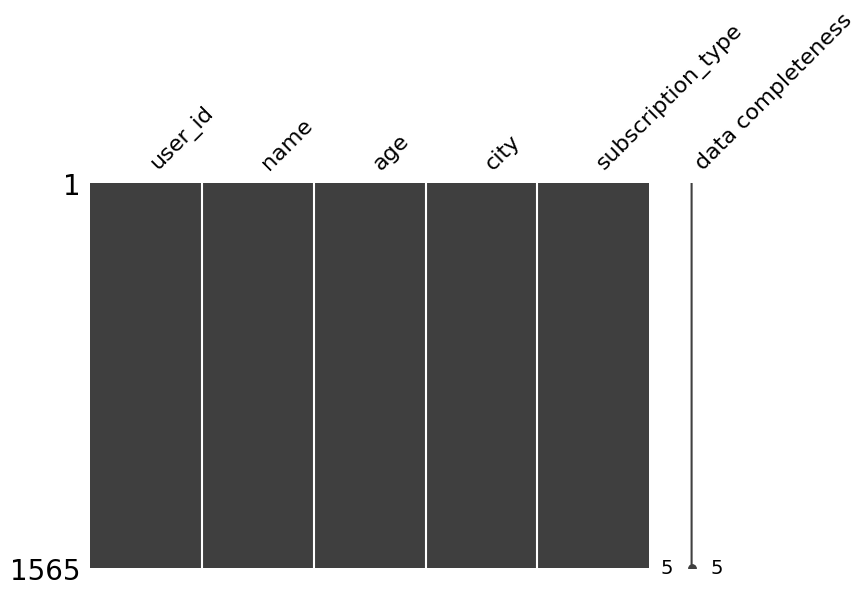

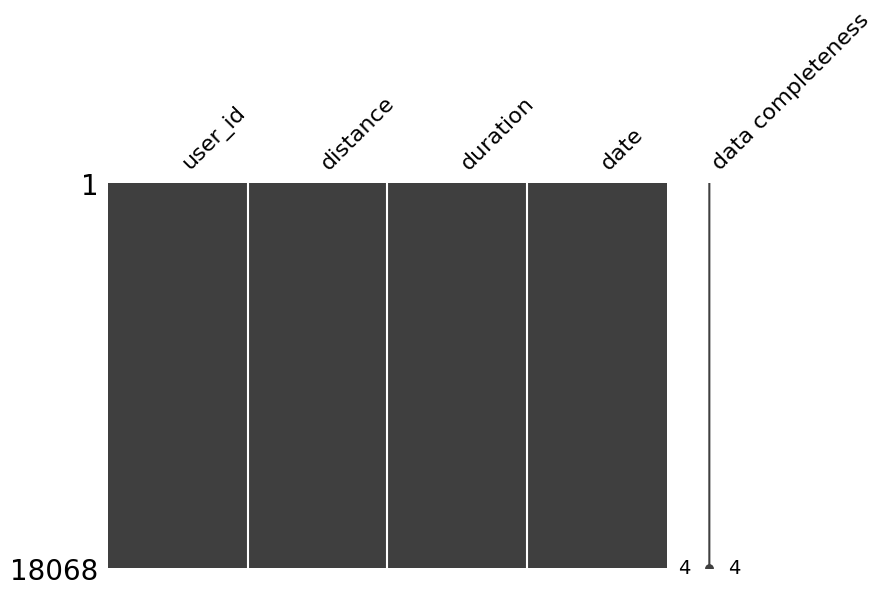

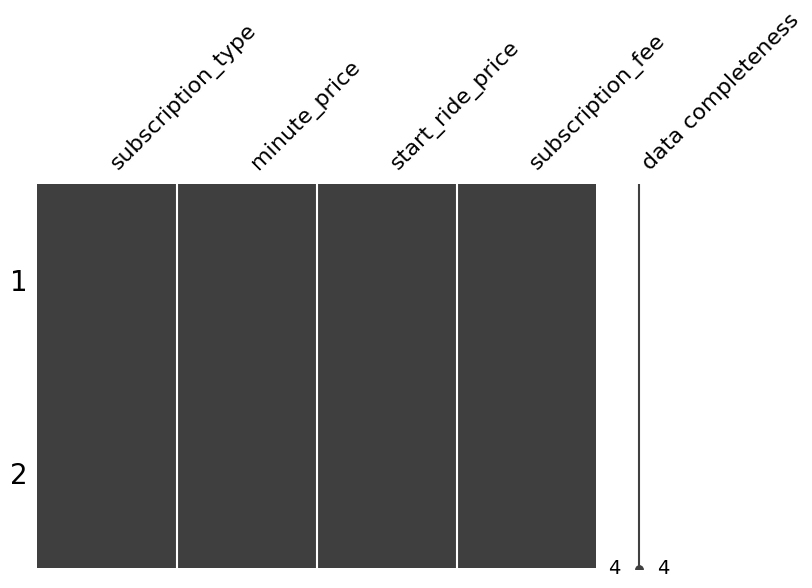

In [6]:
dates = [users_go, rides_go, subscriptions_go] # Лист с датафреймами
# Цикл для проверки кол-ва пропусков
for data in dates:
    msno.matrix(data, labels=True, figsize=(8, 5))

Анализируя полученные визуализации по пропускам, можно сделать вывод что в датафреймах: `users_go`, `rides_go` и `subscriptions_go` пропуски отсутствуют.

In [7]:
# Изменение формата данных с object на datetime
rides_go['date'] = pd.to_datetime(rides_go['date'], format='%Y-%m-%d')

In [8]:
# Добавление столбца с номером месяца
rides_go['month'] = rides_go['date'].dt.month
# Проверка
rides_go.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


In [9]:
def find_variable_name(obj):
    """
    Нахождение имени переменной в которой лежит датафрейм
    """
    for var_name, var_value in globals().items():
        if var_value is obj:
            return var_name
    return None


for data in dates:
    var_name = find_variable_name(data)  # Находим имя переменной
    if var_name:
        print(f'Количество дубликатов в датафрейме {var_name} равно {data.duplicated().sum()}')
    else:
        print('Имя переменной не найдено.')

Количество дубликатов в датафрейме users_go равно 31
Количество дубликатов в датафрейме rides_go равно 0
Количество дубликатов в датафрейме subscriptions_go равно 0


In [10]:
# Удаление явных дубликатов
users_go = users_go.drop_duplicates()
# Проверка
users_go.duplicated().sum()

0

В ходе предобработки данных:
- произвена проверка на наличие пропусков;
- были обнаружены и удалены дубликаты в датафрейме `users_go`;
- изменение формата данных с `object` на `datetime` в столбце `date` датафрейма `riders_go`;
- добавление номера месяца в новый столбец `month` датафрейма `riders_go`.

<a class="anchor" id="3-bullet"></a>
## Исследовательский анализ данных

<a class="anchor" id="3.1-bullet"></a>
### Частота встречаемости городов

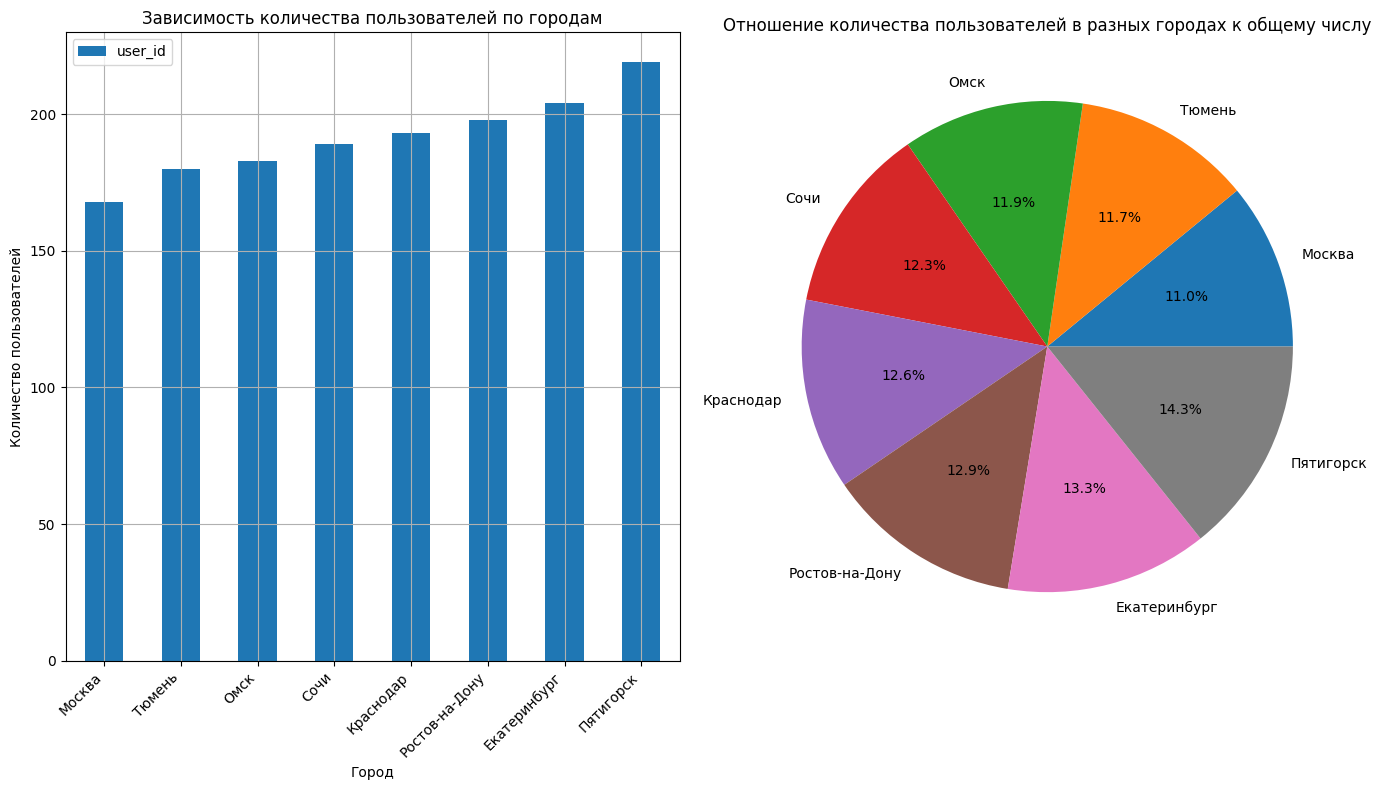

,user_id
city,
Пятигорск,219
Екатеринбург,204
Ростов-на-Дону,198
Краснодар,193
Сочи,189
Омск,183
Тюмень,180
Москва,168


In [11]:
# Создаем фигуру с двумя подграфиками (2 строки, 1 колонка)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

# Столбчатая диаграмма
users_go.pivot_table(index='city', values='user_id', aggfunc='count') \
    .sort_values(by='user_id') \
    .plot(
    kind='bar',
    grid=True,
    ax=ax1,
    title='Зависимость количества пользователей по городам',
    ylabel='Количество пользователей'
)

ax1.set_xlabel('Город')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')


# Круговая диаграмма
users_go.pivot_table(index='city', values='user_id', aggfunc='count') \
    .sort_values(by='user_id') \
    .plot(
    kind='pie',
    y='user_id',
    autopct='%1.1f%%',
    legend=False,
    ax=ax2,
    title='Отношение количества пользователей в разных городах к общему числу')

ax2.set_ylabel('')

# Показываем графики
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

# Вывод сводной таблицы
users_go.pivot_table(
    index='city', values='user_id', aggfunc='count'
).sort_values(by='user_id', ascending=False)

| Город | Количество пользователей | Численность населения |
|-------|--------------------------|-----------------------|
| Пятигорск | 219 | 145 000 |
| Екатеринбург | 204 | 1 560 000 |
| Ростов-на-Дону | 198 | 1 140 000 |
| Краснодар | 193 | 1 000 000 |
| Сочи | 189 | 500 000 |
| Омск | 183 | 1 120 000 |
| Тюмень | 180 | 830 000 |
| Москва | 168 | 13 000 000 |

Наблюдения:
- Пятигорск (145 000 жителей) лидирует по количеству пользователей, хотя его население намного меньше, чем у других городов. Это может указывать на высокую популярность прокатных сервисов среди населения.  
- Москва с наибольшим населением (13 млн) имеет самое низкое количество пользователей (168), что может свидетельствовать о насыщении рынка или наличии множества альтернативных транспортных средств.   
- В южных городах, таких как Пятигорск, Ростов-на-Дону, Краснодар и Сочи, наблюдается стабильная высокая активность пользователей, что может быть связано с благоприятными климатическими условиями и активным туристическим потоком.  
- Екатеринбург занимает второе место по количеству пользователей, что выделяет его среди северных городов.

**Вывод:**
Данные демонстрируют, что количество пользователей сервиса GoFast не всегда пропорционально численности населения. Небольшие города, такие как Пятигорск, могут иметь высокий уровень использования услуг, в то время как крупные мегаполисы, такие как Москва, могут показывать более низкие показатели из-за различных факторов, таких как насыщение рынка и доступность альтернативного транспорта.

<a class="anchor" id="3.2-bullet"></a>
### Cоотношение пользователей с подпиской и без подписки

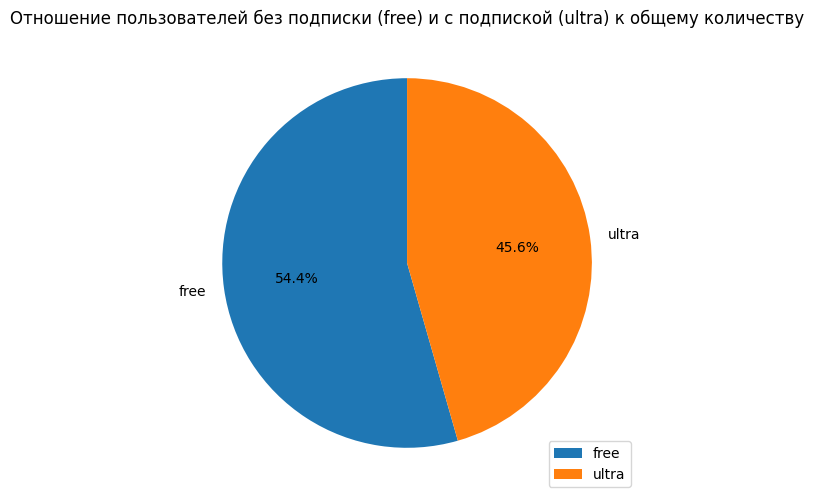

,user_id
subscription_type,
ultra,699
free,835


In [12]:
(
    users_go.pivot_table(index='subscription_type', values='user_id', aggfunc='count')
    .plot(kind='pie', y='user_id', figsize=(6, 6),
    autopct='%1.1f%%', startangle=90,
    title='Отношение пользователей без подписки (free) и с подпиской (ultra) к общему количеству')
)
plt.ylabel(None)
plt.show()
users_go.pivot_table(
    index='subscription_type', values='user_id', aggfunc='count'
).sort_values(by='user_id')

**Вывод:** Несмотря на то, что пользователи без подписки составляют 54,4%, а с подпиской `ultra` — 45,6%, разрыв между ними незначителен, что свидетельствует о схожем уровне интереса к обоим вариантам.

<a class="anchor" id="3.3-bullet"></a>
### Возраст пользователей

Информация о возрасте пользователей


count    1534.0
mean       24.9
std         4.6
min        12.0
25%        22.0
50%        25.0
75%        28.0
max        43.0
Name: age, dtype: float64

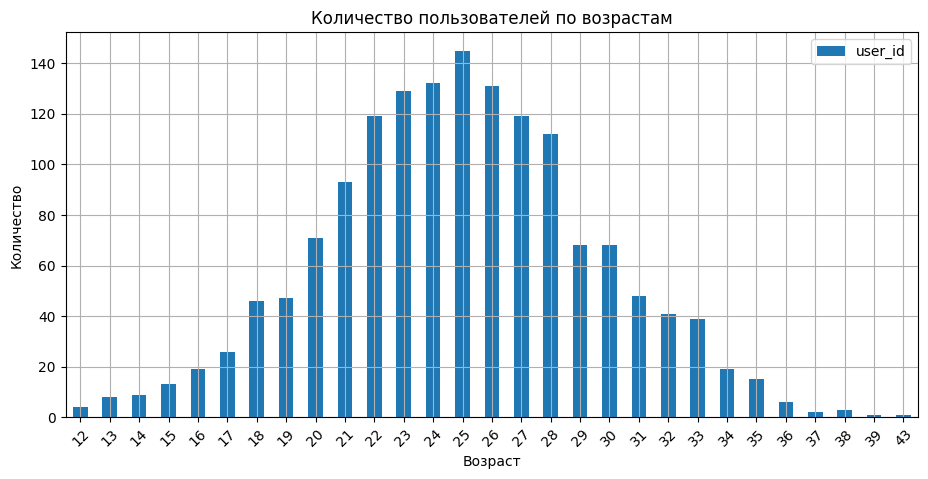

In [13]:
print("\033[1mИнформация о возрасте пользователей\033[0m")
display(users_go['age'].describe().round(1))

(
    users_go.pivot_table(index='age', values='user_id', aggfunc='count')
    .sort_values(by='age', ascending=True)
    .plot(kind='bar' , grid=True, figsize=(11, 5))
)
plt.xticks(rotation=45)
plt.title('Количество пользователей по возрастам')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show()

**Вывод:** Зависимость количества пользователей от возраста указывает, что средний возраст потребителя услуги подчиняется нормальному распределению с медианой примерно в 25 лет, при этом средний возраст и медиана практически совпадают.

<a class="anchor" id="3.4-bullet"></a>
### Расстояние, которое пользователь преодолел за одну поездку

Информация о расстоянии преодолеваемым пользователем


count    18068.0
mean      3070.7
std       1116.8
min          0.9
25%       2543.2
50%       3133.6
75%       3776.2
max       7211.0
Name: distance, dtype: float64

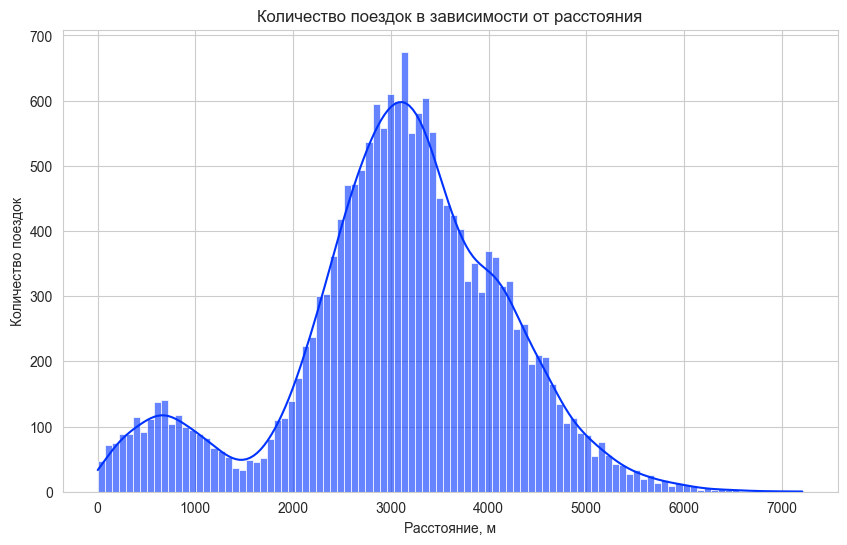

In [14]:
print("\033[1mИнформация о расстоянии преодолеваемым пользователем\033[0m")
display(rides_go['distance'].describe().round(1))

plt.figure(figsize=(10, 6)) # Задание размера графика
sns.set_style('whitegrid') # Задание сетки
sns.histplot(data=rides_go,
             x='distance',
             color="#0033FF",
             alpha=0.6,
             kde=True,
             stat='count',
             bins=100,
            )

plt.title('Количество поездок в зависимости от расстояния')
plt.xlabel('Расстояние, м')  # Переименование оси X
plt.ylabel('Количество поездок')  # Переименование оси Y
plt.show()

**Вывод:** График распределения количества поездок в зависимости от расстояния, представляет собой нормальное распределение, с четко выраженной колоколообразной формой. Основная масса поездок сосредоточена в диапазоне от 2000 до 4000 метров. Медиана расстояния равна 3134 м, а среднее растояние 3070 м.
Различие между медианой и средним вызвано наличием 2-го горба на графике в районе 600 м.

<a class="anchor" id="3.5-bullet"></a>
### Продолжительность поездок

Информация о времени которое затрачивает пользователь на поездку


count    18068.0
mean        17.8
std          6.1
min          0.5
25%         13.6
50%         17.7
75%         21.7
max         40.8
Name: duration, dtype: float64

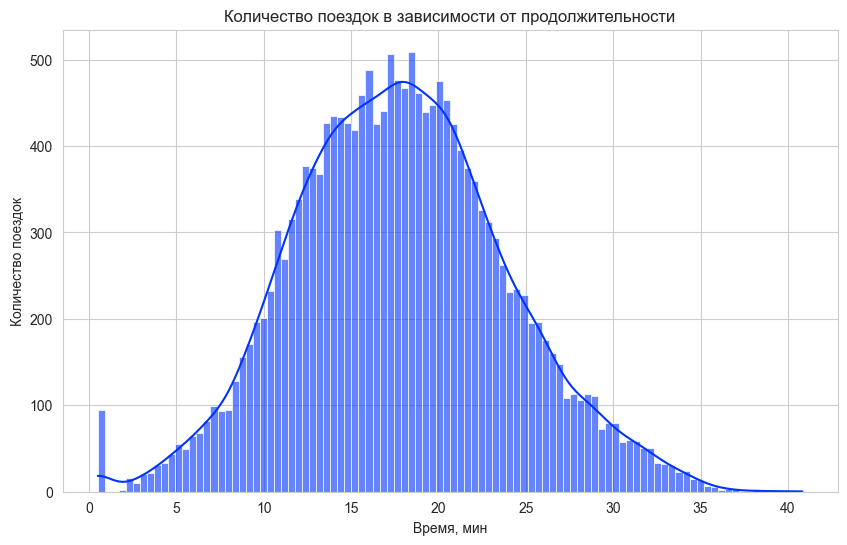

In [15]:
print("\033[1mИнформация о времени которое затрачивает пользователь на поездку\033[0m")
display(rides_go['duration'].describe().round(1))

plt.figure(figsize=(10, 6)) # Задание размера графика
sns.set_style('whitegrid') # Задание сетки
sns.histplot(data=rides_go,
             x='duration',
             color="#0033FF",
             alpha=0.6,
             kde=True,
             stat='count',
             bins=100,
            )

plt.title('Количество поездок в зависимости от продолжительности')
plt.xlabel('Время, мин')  # Переименование оси X
plt.ylabel('Количество поездок')  # Переименование оси Y
plt.show()

**Вывод:** График распределения количества поездок в зависимости от продолжительности, представляет собой нормальное распределение, с четко выраженной колоколообразной формой. Основная масса поездок сосредоточена в диапазоне от 13.5 до 21.7 минут. Медиана времени равна 17.7 минут, а среднее время 17.8 минут.  

На графике имеется выброс с длительностью поездки менее минуты, следует более подробно изучить данную аномалию.

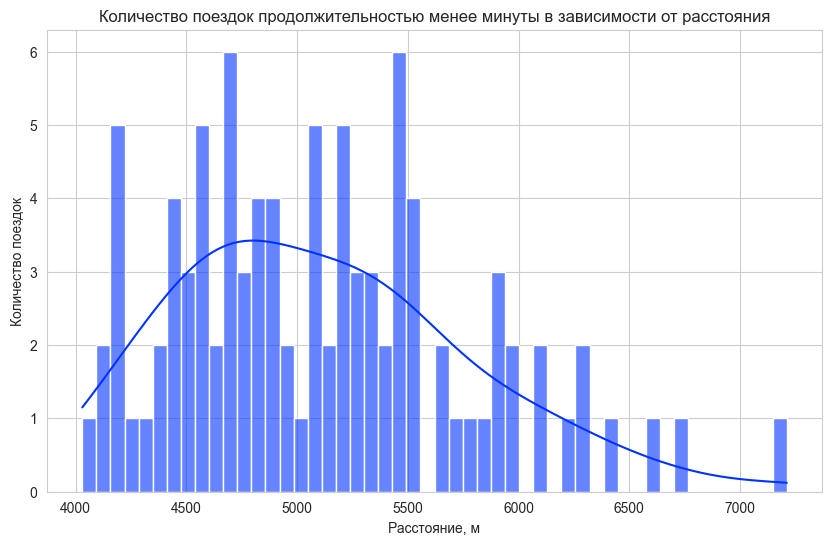

Диапазон скорости для аренды самокатов менее минуты: от 484 км/ч до 865 км/ч


In [16]:
# Фильтрация поездок продолжительностью менее минуты
short_ride = rides_go.query('duration < 1')

# Настройка графика
plt.figure(figsize=(10, 6))  # Задание размера графика
sns.set_style('whitegrid')  # Задание сетки

# Построение гистограммы
sns.histplot(data=short_ride,
             x='distance',
             color="#0033FF",
             alpha=0.6,
             kde=True,
             stat='count',
             bins=50,
            )

# Подписи и заголовки
plt.title('Количество поездок продолжительностью менее минуты в зависимости от расстояния')
plt.xlabel('Расстояние, м')  # Переименование оси X
plt.ylabel('Количество поездок')  # Переименование оси Y
plt.show()

# Расчёт диапазона скорости
METR_IN_KM = 1000
MINUT_IN_HOUR = 60

low_bracket = (
    short_ride['distance'].min() / short_ride['duration'].max() 
    * MINUT_IN_HOUR / METR_IN_KM
)
high_bracket = (
    short_ride['distance'].max() / short_ride['duration'].max() 
    * MINUT_IN_HOUR / METR_IN_KM
)

# Вывод диапазона скорости
print(f'Диапазон скорости для аренды самокатов менее минуты: '
      f'от {low_bracket:.0f} км/ч до {high_bracket:.0f} км/ч')

Расчет средней скорости указывает, что в некоторых случаях самокаты перемещались со средней скоростью от 484 до 865 км/ч, самокатов способных развить такие скорости на 2024 г. не существует. О данной аномалии необходимо сообщить владельцам проката для ее устранения.

**Общий вывод**

В ходе исследовательского анализа данных сервиса GoFast выявил интересные тенденции, показывающие сложную зависимость между количеством пользователей и характеристиками городов.

- **Количество пользователей и население:** Количество пользователей сервиса GoFast не всегда пропорционально численности населения. Небольшие города, такие как Пятигорск, могут иметь высокий уровень использования услуг, в то время как крупные мегаполисы, такие как Москва, могут показывать более низкие показатели из-за различных факторов, таких как насыщение рынка и доступность альтернативного транспорта.

- **Региональные особенности:** Южные города, такие как Пятигорск, Ростов-на-Дону, Краснодар и Сочи, демонстрируют высокую активность пользователей благодаря благоприятным климатическим условиям и туристическому потоку.

- **Подписка и интерес:** Доля пользователей без подписки (54,4%) и с подпиской ultra (45,6%) почти равны, что указывает на схожий интерес к обоим вариантам.

- **Возраст пользователей:** Средний возраст пользователей, имеющий нормальное распределение с медианой около 25 лет, указывает на молодежную аудиторию.

- **Расстояние и продолжительность поездок:** Основная масса поездок сосредоточена в диапазоне от 2000 до 4000 метров и от 13.5 до 21.7 минут соответственно. Наблюдаются выбросы, связанные с короткими поездками, что может быть результатом специфики использования сервиса.

- **Аномалии средней скорости:** Для самокатов аренда которых состовляет менее минуты, замечена аномалия записи средней скорости, вероятная причина этого явления связана с тем, что для некоторых самокатах некоректно записывается время аренды (оно обрывается в течение минуты, без фактического завершения аренды).

<a class="anchor" id="4-bullet"></a>
## Объединение данных

<a class="anchor" id="4.1-bullet"></a>
###  Объединие данных о пользователях, поездках и подписках в один датафрейм.

In [17]:
united_df = pd.merge(users_go, subscriptions_go, on='subscription_type')
united_df = pd.merge(rides_go, united_df, on='user_id')

# Округляем значения дистанции до ближайшего целого числа
united_df['distance'] = united_df['distance'].round()

In [18]:
# Вывод информации об объединенном датафрейме
united_df.info()
# Проверка
united_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   distance           18068 non-null  float64       
 2   duration           18068 non-null  float64       
 3   date               18068 non-null  datetime64[ns]
 4   month              18068 non-null  int32         
 5   name               18068 non-null  object        
 6   age                18068 non-null  int64         
 7   city               18068 non-null  object        
 8   subscription_type  18068 non-null  object        
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(3)
memory usage: 1.6+ MB


,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4410.0,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2618.0,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.0,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2695.0,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4029.0,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


**Вывод:** Полученный объединенный датафрейм имеет 12 столбцов и 18068 строк.

<a class="anchor" id="4.2-bullet"></a>
### Создание отдельных датафреймов для пользователей с подпиской и без

In [19]:
# Фильтруем строки из DataFrame united_df, где тип подписки 'free'
sub_free = united_df.query("subscription_type == 'free'")
# Фильтруем строки из DataFrame united_df, где тип подписки 'ultra'
sub_ultra = united_df.query("subscription_type == 'ultra'")

# Проверка успешной фильтрации данных
'Разделение прошло успешно' if len(united_df) == (len(sub_free) + len(sub_ultra)) \
else 'ВНИМАНИЕ, что то пошло не так'

'Разделение прошло успешно'

**Вывод:** Полученны два отфильтрованных датафрейма в зависимости от наличия подписки пользователя GoFast.

<a class="anchor" id="4.3-bullet"></a>
### Визуализация информации о расстоянии и времени поездок для пользователей обеих категорий

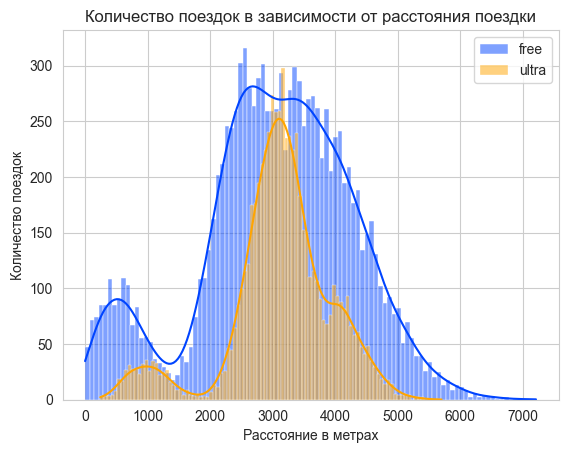

"Отображение статистической информации для sub_free ['distance']"

count    11568.0
mean      3045.0
std       1246.0
min          1.0
25%       2367.0
50%       3115.0
75%       3906.0
max       7211.0
Name: distance, dtype: float64

"Отображение статистической информации для sub_ultra ['distance']"

count    6500.0
mean     3115.0
std       837.0
min       244.0
25%      2785.0
50%      3149.0
75%      3561.0
max      5700.0
Name: distance, dtype: float64

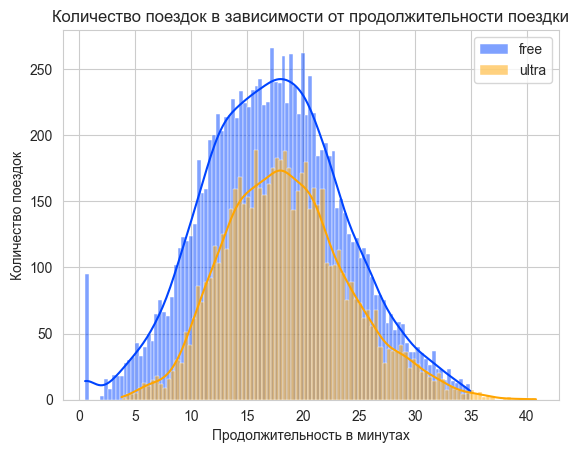

"Отображение статистической информации для sub_free ['duration']"

count    11568.0
mean        17.0
std          6.0
min          0.0
25%         13.0
50%         17.0
75%         22.0
max         35.0
Name: duration, dtype: float64

"Отображение статистической информации для sub_ultra ['duration']"

count    6500.0
mean       19.0
std         6.0
min         4.0
25%        15.0
50%        18.0
75%        22.0
max        41.0
Name: duration, dtype: float64

In [20]:
for data in ['distance', 'duration']:
    # Создаем гистограмму для 'free'
    sns.histplot(sub_free[data], bins=100, label='free', color="#0044FF", alpha=0.5, kde=True)
    
    # Создаем гистограмму для 'ultra'
    sns.histplot(sub_ultra[data], bins=100, label='ultra', color='orange', alpha=0.5, kde=True)
        
    plt.legend(loc='upper right')
    
    if data == 'distance':
        plt.title('Количество поездок в зависимости от расстояния поездки')
        plt.xlabel('Расстояние в метрах')
    else:
        plt.title('Количество поездок в зависимости от продолжительности поездки')
        plt.xlabel('Продолжительность в минутах')
    
    plt.ylabel('Количество поездок')
    plt.grid(True)
    plt.show()
    
    display(f"Отображение статистической информации для sub_free {[data]}", sub_free[data].describe().round(0))
    
    display(f"Отображение статистической информации для sub_ultra {[data]}", sub_ultra[data].describe().round(0))

**Общий вывод:** 
В 4 пункте анализа были выполнены следующие работы:
- был создан один общий датафрейм, объединивший данные о пользователях, поездках и подписках;
- были созданы два отдельных датафрейма `sub_free` и `sub_ultra`, в зависимости от наличия или отсутствия подписки;

Анализируя графики распределения количества поездок от расстояния и продолжительности, можно сделать несколько выводов:
- без подписки совершается больше поездок `11568`, чем с ней `6500`;
- пользователи с подпиской более предсказуемы в пройденном расстоянии, что говорит меньшее среднее отклонение `837` по сравнению с пользователями без подписки неё `1246`;
- пользователи с подпиской не совершают слишком короткие (< 100м) и слишком длинные (> 5800м) поездки;
- у пользователей с подпиской наблидается небольшой сдвиг вправо медианы и среднего значения для расстояния и продолжительности поездки<br>(без подписки: **mean** = 3045м и 17 минут, **median** = 3115м и 18 минут; с подпиской: **mean** = 3115м и 19 минут, **median** = 3149м и 18 минут)
- на графике распределения продолжительности поездки заметно, что пользователи с подпиской не используют слишком короткие поездки (< 4 минут) и напротив у пользователей присутствуют слишком долгие поездки (> 35 минут).

Подитожив можно сделать вывод, что **поведение пользователей с подпиской и без различны.**

<a class="anchor" id="5-bullet"></a>
## Подсчёт выручки

<a class="anchor" id="5.1-bullet"></a>
### Нахождение суммарного расстояние, количества поездок и суммарного время для каждого пользователя за каждый месяц

In [21]:
# Создаем сводную таблицу, добавляя новые столбцы: 'minute_price', 'start_ride_price', 'subscription_fee'
users_months_revenue = united_df.pivot_table(
    index=('user_id', 'month'),  # Индексы — пользователь и месяц
    values=(
        'distance',  # Расстояние поездки
        'duration',  # Длительность поездки
        'minute_price',  # Цена за минуту
        'start_ride_price',  # Стоимость начала поездки
        'subscription_fee'  # Плата за подписку
    ), 
    aggfunc={
        'distance': {'count', 'sum'},  # Количество поездок и общая дистанция
        'duration': 'sum',  # Общая длительность поездок
        'minute_price': 'mean',  # Средняя цена за минуту
        'start_ride_price': 'mean',  # Средняя стоимость начала поездки
        'subscription_fee': 'mean'  # Средняя плата за подписку
    }
)

# Переименовываем столбцы для удобства
users_months_revenue.columns = [
    'count',  # Количество поездок
    'distance',  # Общая дистанция
    'duration',  # Общая длительность
    'minute_price',  # Средняя цена за минуту
    'start_ride_price',  # Средняя стоимость начала поездки
    'subscription_fee'  # Средняя плата за подписку
]

# Округляем значения продолжительности с помощью "потолка"
united_df['duration'] = np.ceil(united_df['duration'])

# Выводим первые 10 строк таблицы
users_months_revenue.head(10)

count  distance   duration  minute_price  start_ride_price  \
user_id month                                                               
1       1          2    7028.0  41.416640           6.0               0.0   
        4          1     754.0   6.232113           6.0               0.0   
        8          2    6724.0  44.776802           6.0               0.0   
        10         2    5810.0  31.578017           6.0               0.0   
        11         3    7004.0  53.397424           6.0               0.0   
        12         2    6752.0  27.203912           6.0               0.0   
2       3          3   10188.0  60.959959           6.0               0.0   
        4          2    6165.0  39.048633           6.0               0.0   
        6          1    3255.0  13.851127           6.0               0.0   
        7          2    6781.0  46.170157           6.0               0.0   

               subscription_fee  
user_id month                    
1       1                 199.0  
        4                 199.0  
        8                 199.0  
        10                199.0  
        11                199.0  
        12                199.0  
2       3                 199.0  
        4                 199.0  
        6                 199.0  
        7                 199.0

<a class="anchor" id="5.2-bullet"></a>
### Добавление столбеца с помесячной выручкой, которую принёс каждый пользователь.

,revenue
month,
Январь,332290.0
Май,331533.0
Июнь,330313.0
Март,324269.0
Июль,323072.0
Декабрь,320541.0
Август,320029.0
Сентябрь,317510.0
Апрель,317425.0


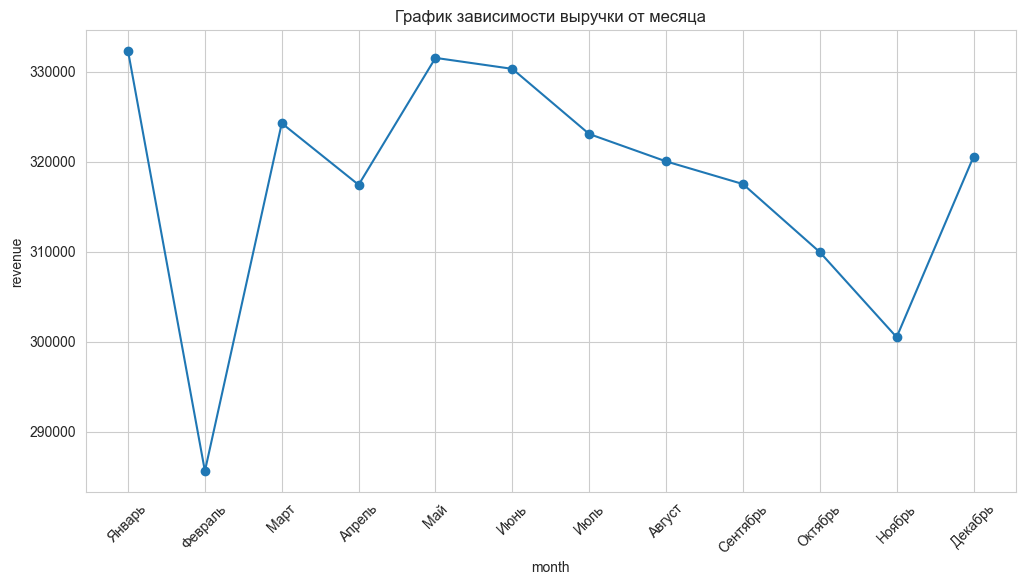

Вывод: Выручка сервиса GoFast за год составила: 3813029 руб.


In [22]:
# Расчет помесячной выручки и добавление его в датафрейм
users_months_revenue['revenue'] = (
    users_months_revenue['start_ride_price'] * users_months_revenue['count'] +  # Доход от стартовой стоимости поездок
    users_months_revenue['minute_price'] * users_months_revenue['duration'] +   # Доход от времени в пути
    users_months_revenue['subscription_fee']  # Подписка
)

# Подсчет общей ежемесячной выручки с помощью сводной таблицы
month_amount = users_months_revenue.pivot_table(
    index='month',  # Индекс — месяц (номер месяца)
    values='revenue',  # Значение — выручка
    aggfunc='sum'  # Суммируем выручку
).round()  # Округление результата

# Заменяем номера месяцев на их имена без создания словаря
month_amount.index = pd.to_datetime(month_amount.index, format='%m').month_name(locale='ru_RU')

# Отображаем полученные данные
display(month_amount.sort_values(by='revenue', ascending=False))

month_amount.plot(
    y='revenue', 
    ylabel='revenue', 
    legend=None, 
    xlabel='month',
    kind='line', 
    marker='o', 
    grid=True, 
    figsize=(12, 6)
)
plt.xticks(range(len(month_amount.index)), month_amount.index, rotation=45)
plt.title("График зависимости выручки от месяца")
plt.show()

# Подсчет общей годовой выручки
year_amount = month_amount['revenue'].sum()  # Вычисляем сумму по всем месяцам
print('\033[1mВывод:\033[0m Выручка сервиса \033[1mGoFast\033[0m за год составила:', int(year_amount), 'руб.')

Самым прибыльным месяцем является Январь, далее идут Май, Июнь и Март. Наименее прибыльны Февраль и Ноябрь. Из выше перечисленного можно заметить, что наибольшую прибыль имеют месяцы с праздниками или летние месяцы, когда люди отдыхают.

<a class="anchor" id="6-bullet"></a>
## Проверка гипотез

<a class="anchor" id="6.1-bullet"></a>
### Тратят ли пользователи с подпиской больше времени на поездки?

Выдвенем гипотезы:
- Н0: Средняя продолжительность поездок с подпиской (`ultra`) и без подписки (`free`) равны
- Н1: Средняя продолжительность поездок с подпиской (`ultra`) больше продолжительности поездок без подписи (`free`)

Произведем проверку этой гипотезы с использованием t-теста

Уточним какой параметр использовать для t-теста (equal_var=True или equal_var=False)

In [23]:
# Тест Левене для проверки равенства дисперсий
stat, p_value = levene(sub_ultra['duration'], sub_free['duration'])
print(f'p-value теста Левене: {p_value}')

# Если p-value < 0.05, то дисперсии различаются
if p_value < 0.05:
    print('Дисперсии различаются, рекомендуется использовать t-тест Уэлча')
else:
    print('Дисперсии равны, можно использовать классический t-тест')

p-value теста Левене: 3.246265173544774e-31
Дисперсии различаются, рекомендуется использовать t-тест Уэлча


In [24]:
# Уровень значимости: порог для отклонения нулевой гипотезы равный 5%
alpha = 0.05

# Выполняем t-тест для двух независимых выборок (длительность поездок у пользователей "ultra" и "free")
results = st.ttest_ind(
    sub_ultra['duration'], 
    sub_free['duration'],
    alternative='greater') # Односторонний тест: проверяем, что средняя длительность поездок "ultra" больше
print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

1.2804098316645613e-34
Отвергаем нулевую гипотезу


**Вывод:** У пользователей с подпиской `ultra` среднее продолжительность поездки больше, чем у пользователей без подписки, при установленном уровне значимости в 5 %.

<a class="anchor" id="6.2-bullet"></a>
### Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката

Выдвенем гипотезы:
- Н0: Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, равно 3130 метров
- Н1: Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не равно 3130 метров

In [25]:
distance = 3130  # Установленное значение, с которым будем сравнивать среднее значение выборки
alpha = 0.05  # Уровень значимости (5%)

# t-тест для одной выборки, чтобы проверить, отличается ли среднее значение выборки от 3130
results = st.ttest_1samp(
    sub_ultra['distance'], 
    distance,
)

print(results.pvalue)

# Если p-value < alpha (0.05), отвергаем нулевую гипотезу
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

0.1608700210604552
Не получилось отвергнуть нулевую гипотезу


**Вывод:** Так как нулевую гипотезу отвергнуть не удалось, то среднее расстояние которое проезжают пользователи с подпиской равно оптимальному.

<a class="anchor" id="6.3-bullet"></a>
### Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Выдвенем гипотезы:
- Н0: Помесячная средняя выручка от пользователей с подпиской равна помесячной средней выручке от пользователей без подписки.
- Н1: Помесячная средняя выручка от пользователей с подпиской больше помесячной средней выручки от пользователей без подписки.

In [26]:
# Выборка выручки для пользователей с подпиской (где subscription_fee > 0)
revenue_with_subscription = users_months_revenue.query('subscription_fee > 0')['revenue']
# Выборка выручки для пользователей с подпиской (где subscription_fee = 0)
revenue_without_subscription = users_months_revenue.query('subscription_fee == 0')['revenue']

In [27]:
# Тест Левене для проверки равенства дисперсий
stat, p_value = levene(revenue_with_subscription, revenue_without_subscription)
print(f'p-value теста Левене: {p_value}')

# Если p-value < 0.05, то дисперсии различаются
if p_value < 0.05:
    print('Дисперсии различаются, рекомендуется использовать t-тест Уэлча')
else:
    print('Дисперсии равны, можно использовать классический t-тест')

p-value теста Левене: 4.371662389951912e-268
Дисперсии различаются, рекомендуется использовать t-тест Уэлча


In [28]:
# Выполнение t-теста для двух независимых выборок
results = st.ttest_ind(
    revenue_with_subscription,  # Выручка пользователей с подпиской
    revenue_without_subscription,  # Выручка пользователей без подписки
    alternative='greater'  # Альтернативная гипотеза: средняя выручка с подпиской больше, чем без подписки
)

# Вывод p-value
print(results.pvalue)

# Уровень значимости (alpha = 5%)
alpha = 0.05

# Если p-value меньше уровня значимости (0.05), отвергаем нулевую гипотезу
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')  # Средняя выручка с подпиской статистически больше, чем без подписки
else:
    print('Не получилось отвергнуть нулевую гипотезу')  # Нет статистически значимого различия

2.899911210580282e-37
Отвергаем нулевую гипотезу


**Вывод:** Нулевая гипотеза отвергнута, средняя месячная выручка от пользователей с подпиской, больше средней месячной выручки от пользователей без подписки, при установленном уровне значимости в 5 %.

<a class="anchor" id="6.4-bullet"></a>
### Обращений в техподдержку

Условие задачи:  

Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Выдвенем гипотезы:

- Н0: Количество обращений в техподдержку после обновления не изменилось.
- Н1: Количество обращений в техподдержку после обновления значимо уменьшилось.

**Вывод:** Выборки в этом случае зависимые, иначе — парными. Парная выборка означает, что некоторая переменная измеряется дважды для одних и тех же объектов (до обновления и после). В этом случае можно применить метод `scipy.stats.ttest_rel()`, при проверке гипотезы, следует указать `alternative="less"`.

<a class="anchor" id="7-bullet"></a>
## Распределения

<a class="anchor" id="7.1-bullet"></a>
### Количество промокодов

Условие задачи:

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %.  
Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

**Решение:**

Минимальное количество промокодов для выполнения плана: 1161


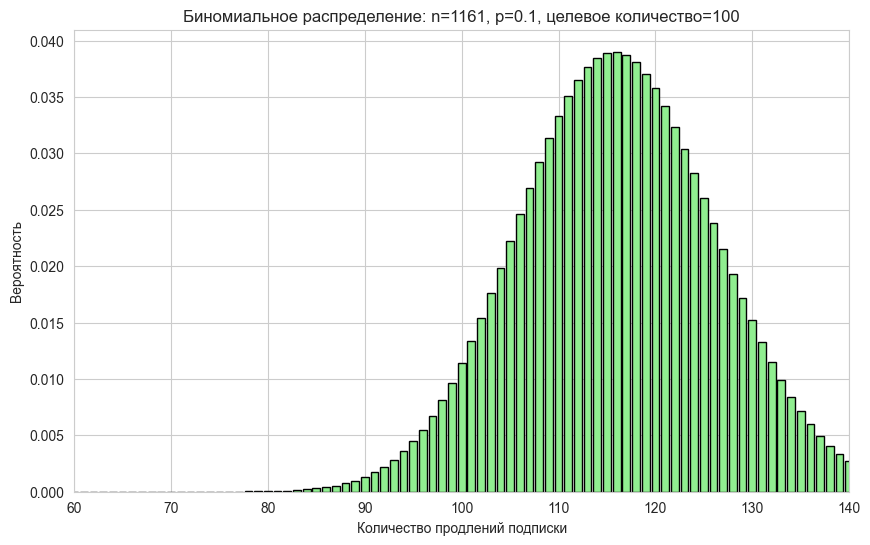

In [31]:
# Задаем параметры
p = 0.1  # вероятность продления подписки (успех)
failure_prob = 0.05  # вероятность не выполнить план (5%)
k = 100  # хотя бы 100 пользователей продлевает

# Функция для нахождения минимального n, чтобы вероятность не выполнить план была <= 5%
def find_min_n(p, k, failure_prob):
    n = k  # начальное значение для n (должно быть больше или равно k)
    while True:
        # Вероятность того, что продлило менее k пользователей из n
        prob_not_enough_successes = st.binom.cdf(k - 1, n, p)
        if prob_not_enough_successes <= failure_prob:
            return n
        n += 1

# Находим минимальное n
n_min = find_min_n(p, k, failure_prob)
print(f"Минимальное количество промокодов для выполнения плана: {n_min}")

# Строим график биномиального распределения для найденного n
x = np.arange(0, n_min + 1)
binom_pmf = st.binom.pmf(x, n_min, p)

# Построим график распределения
plt.figure(figsize=(10, 6))
plt.bar(x, binom_pmf, color='lightgreen', edgecolor='black')
plt.title(f"Биномиальное распределение: n={n_min}, p={p}, целевое количество={k}")
plt.xlabel("Количество продлений подписки")
plt.ylabel("Вероятность")
plt.xlim([k - 40, k + 40])  # сосредоточимся на области около 100 продлений
plt.show()

**Вывод:** Чтобы как минимум 100 существующих клиентов продлили подписку с вероятностью не менее 95 % **необходимо раздать** `1161` промокод.

<a class="anchor" id="7.2-bullet"></a>
### Push-уведомления

Условие задачи:

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений.   
С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

**Решение:**

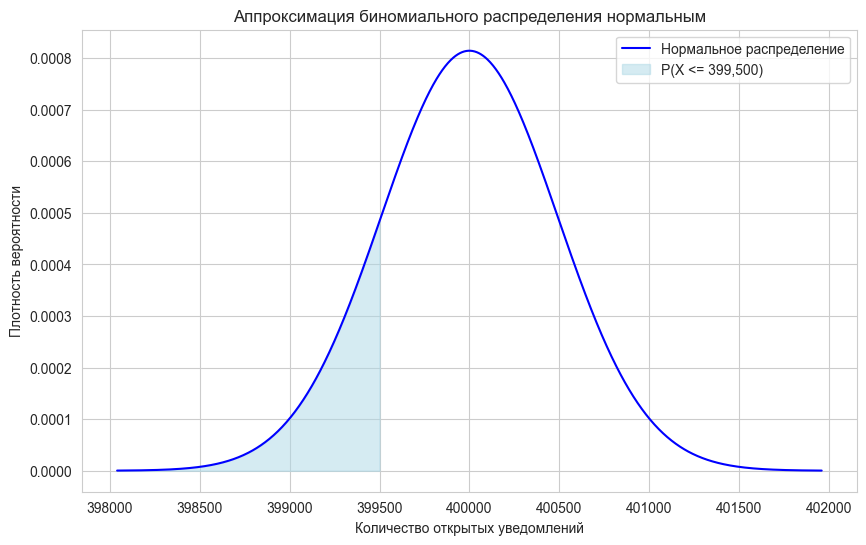

Вывод: вероятность того, что уведомление откроют не более 399.5 тыс. пользователей: 15.4%


In [30]:
# Параметры задачи
n = 1_000_000  # количество разосланных уведомлений
p = 0.4  # вероятность открытия уведомления

# Математическое ожидание и стандартное отклонение для нормальной аппроксимации
mu = n * p  # среднее (мат. ожидание)
sigma = np.sqrt(n * p * (1 - p))  # стандартное отклонение

# Предел, который нас интересует (399.5 тыс. открытий)
threshold = 399_500

# Оценка вероятности P(X <= 399.5 тыс.)
probability = norm.cdf(threshold, mu, sigma)

# Построим график нормального распределения
x = np.linspace(mu - 4 * sigma, mu + 4 * sigma, 1000)  # интервал для x (4 сигмы от среднего)
y = norm.pdf(x, mu, sigma)  # плотность вероятности

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Нормальное распределение', color='blue')
plt.fill_between(x, y, where=(x <= threshold), color='lightblue', alpha=0.5, label=f'P(X <= 399,500)')


plt.title('Аппроксимация биномиального распределения нормальным')
plt.xlabel('Количество открытых уведомлений')
plt.ylabel('Плотность вероятности')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

print(f"\033[1mВывод:\033[0m вероятность того, что уведомление откроют не более 399.5 тыс. пользователей: "
      f"{probability:.1%}")

<a class="anchor" id="8-bullet"></a>
## Общий вывод

В процессе исследования данных о пользователях популярного сервиса аренды самокатов 'GoFast', были выполнены следующие этапы и сделаны выводы:

1. Для статистического анализа сервиса GoFast были получены 3 датафрейма users_go, rides_go, subscriptions_go 
   * Датафрейм users_go состоит из 5 столбцов и 1565 строк:
   * Датафрейм rides_go состоит из 4 столбцов и 18068 строк;
   * Датафрейм subscriptions_go состоит из 4 столбцов и 2 строк.
2. В ходе предобработки данных:
    - произвена проверка на наличие пропусков;
    - были обнаружены и удалены дубликаты в датафрейме `users_go`;
    - изменение формата данных с `object` на `datetime` в столбце `date` датафрейма `riders_go`;
    - добавление номера месяца в новый столбец `month` датафрейма `riders_go`.
3. В ходе исследовательского анализа данных сервиса GoFast выявил интересные тенденции, показывающие сложную зависимость между количеством пользователей и характеристиками городов.
    - **Количество пользователей и население:** Количество пользователей сервиса GoFast не всегда пропорционально численности населения. Небольшие города, такие как Пятигорск, могут иметь высокий уровень использования услуг, в то время как крупные мегаполисы, такие как Москва, могут показывать более низкие показатели из-за различных факторов, таких как насыщение рынка и доступность альтернативного транспорта.
    - **Региональные особенности:** Южные города, такие как Пятигорск, Ростов-на-Дону, Краснодар и Сочи, демонстрируют высокую активность пользователей благодаря благоприятным климатическим условиям и туристическому потоку.
    - **Подписка и интерес:** Доля пользователей без подписки (54,4%) и с подпиской ultra (45,6%) почти равны, что указывает на схожий интерес к обоим вариантам.
    - **Возраст пользователей:** Средний возраст пользователей, имеющий нормальное распределение с медианой около 25 лет, указывает на молодежную аудиторию.
    - **Расстояние и продолжительность поездок:** Основная масса поездок сосредоточена в диапазоне от 2000 до 4000 метров и от 13.5 до 21.7 минут соответственно. Наблюдаются выбросы, связанные с короткими поездками, что может быть результатом специфики использования сервиса.
    - **Аномалии средней скорости:** Для самокатов аренда которых состовляет менее минуты, замечена аномалия записи средней скорости.
4. В ходе объединения и визуализации данных пользователей без подписки free и с подпиской ultra было замечено различие в повелении ланных пользователей.
5. Выручка сервиса `GoFast` за год составила: 3.853.677 руб. На помесячную выручку влияет наличие праздников или отпусков.
6. В ходе проверок гипотез были сделаны следующие выводы:
    - Средняя продолжительность поездок с подпиской (ultra) больше продолжительности поездок без подписи (free);
    - Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, равно оптимальному = 3130 метров;
    - Помесячная средняя выручка от пользователей с подпиской больше помесячной средней выручки от пользователей без подписки;
    - При проверки успешности обновления для обращений в тех. поддержку наиболее рациональным метод `scipy.stats.ttest_rel()`
7. При испольовании биноминального и нормального распределения были сделаны следующие выводы
    - Необходимо довести до подписчиков как минимум 1161 промокода, для того чтобы как минимум 100 существующих клиентов продлили подписку (продлевают подписку 10% пролучивших промокод) с вероятностью 5% не выполнить план.
    - Если разослать 1 млн уведомлени (откроют только 40 % получивших клиентов), тогда вероятность того, что уведомление откроют не более 399,5 тыс. пользователей составит 15,4 %.
    
**Пользователи с подпиской более выгодны для сервиса аренды самокатов**, этот факт следует учесть при проработке стратегии компании.